Notebook exploring treatment of continuous features. Depending on how a particular feature is distributed, we'll either binarize or find optimum binning strategies via a grid search with decision trees. Given we're using a tree-based model, there's no need to worry about transforming these features. 

In [27]:
import sys
sys.path.append('../')

import src.utils.eda as eda
import src.utils.helper as helper
import src.train as train

import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Binarizer
from sklearn.model_selection import train_test_split
from sklearn import set_config
set_config(transform_output = "pandas")

from feature_engine import encoding as ce
from feature_engine.discretisation import DecisionTreeDiscretiser

from sklego.preprocessing import RepeatingBasisFunction

In [28]:
data, discrete, temporal, continuous, categorical = helper.load_base_data()
data.head()

Discrete: ['Latitude', 'Longitude', 'Altitude']
Temporal: ['month', 'hour']
Continuous: ['Humidity', 'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling']
Categorical: ['Location', 'Season']


,Location,Latitude,Longitude,Altitude,Season,Humidity,AmbientTemp,Wind.Speed,Visibility,Pressure,Cloud.Ceiling,PolyPwr,month,hour
0,Camp Murray,47.11,-122.57,25.480965,Winter,81.71997,12.86919,8.053964,16.096495,1010.6,22.028990,2.42769,12,11
1,Camp Murray,47.11,-122.57,25.480965,Winter,96.64917,9.66415,0.000000,16.096495,1011.3,0.701755,2.46273,12,13
2,Camp Murray,47.11,-122.57,25.480965,Winter,93.61572,15.44983,8.053964,16.096495,1011.6,0.976354,4.46836,12,13
3,Camp Murray,47.11,-122.57,25.480965,Winter,77.21558,10.36659,8.053964,3.219299,1024.4,0.183066,1.65364,12,12
4,Camp Murray,47.11,-122.57,25.480965,Winter,54.80347,16.85471,4.832378,4.828948,1023.7,0.274600,6.57939,12,14


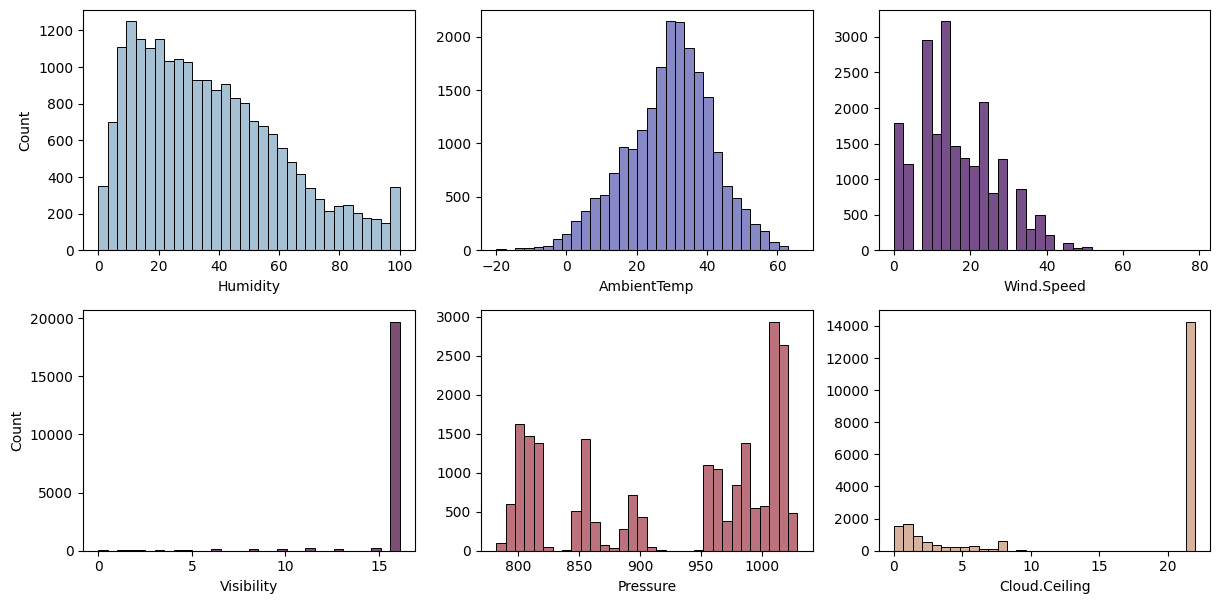

In [29]:
eda.numerical_distributions(df=data, features=continuous)

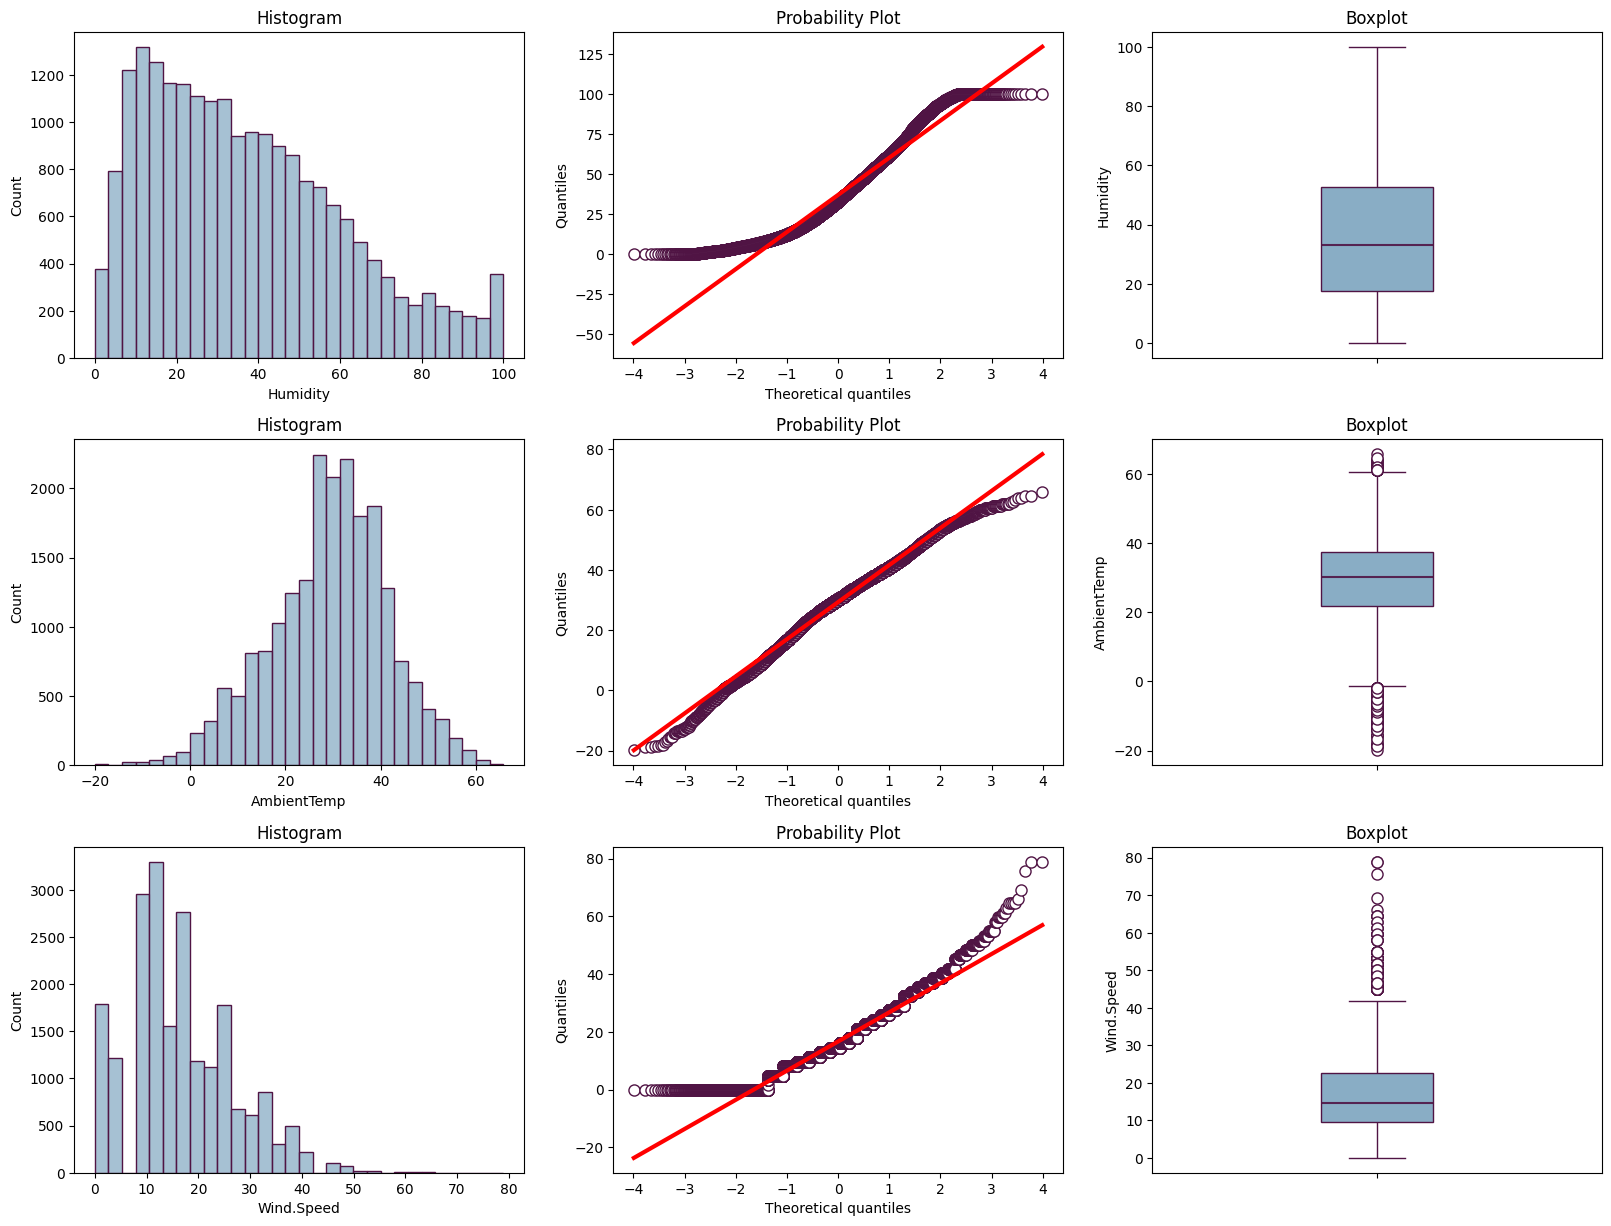

In [30]:
eda.diagnostic_plots(df=data, features=['Humidity', 'AmbientTemp', 'Wind.Speed'])

From the above distributions it looks as though we could discretize humidity, temperature and wind speed, while visibility and cloud ceiling would perhaps be better represented as binary features. Pressure is a bit of a special case since it's a set of normal distributions, one for each location, joined together. We can also see that none of humidity, temperature or wind speed are exactly normal, all presenting differing degrees of skew as well as outliers in temperature and wind speed. 

### Binarization
We'll binarize visibility and cloud ceiling and check the impact on the R2. 

In [31]:
X = data[discrete + temporal + continuous + categorical].copy()

y = data['PolyPwr'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X,  # predictors
    y,  # target
    train_size=0.8,  # percentage of obs in train set
    random_state=0)  # seed to ensure reproducibility

print(X_train.shape, X_test.shape)
print(X.columns)

(16836, 13) (4209, 13)
Index(['Latitude', 'Longitude', 'Altitude', 'month', 'hour', 'Humidity',
       'AmbientTemp', 'Wind.Speed', 'Visibility', 'Pressure', 'Cloud.Ceiling',
       'Location', 'Season'],
      dtype='object')


In [44]:
# RBF step loses the column names so have to index into them directly.
visibility_column_index = 19
cloud_ceiling_column_index = 21

pipeline = Pipeline([
    
    ('rare_label_encoder', 
     ce.RareLabelEncoder(tol=0.05,
                         n_categories=7,
                         variables=['Location'])),
    
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['Season'])),
    
    ('categorical_encoder_loc',
     ce.OrdinalEncoder(encoding_method='arbitrary',
                       variables=['Location'])),
    
    ('rbf_month',
     RepeatingBasisFunction(remainder="passthrough",
                            n_periods=12,
                            column="month",
                            width=1.0,
                            input_range=(1,12))),
    
    ('binarizer_vis_cloudceil', 
     ColumnTransformer(transformers=[('binarize_vis', 
                                      Binarizer(threshold=15), 
                                      [visibility_column_index, cloud_ceiling_column_index])], 
                       remainder='passthrough')),
    
    ('xgb', train.build_model())

])

scores = train.train_model(inputs=X_train, target=y_train, pipeline=pipeline)

CV Average R2: 0.6621033176177378


We get a slight increase in R2 to ~0.662 if we binarize both visibility and cloud ceiling so we'll go with that for now, though we'll also check the latter with discretization below. 

### Discretization
We can find the optimal binning strategy by using decision trees to train on the splits. We'll do this outside of the pipeline and then modify the features themselves to reflect the best bins. 

In [33]:
discretize = [col for col in continuous if col != 'Visibility']

treeDisc = DecisionTreeDiscretiser(
    cv=10, scoring='r2',
    variables=discretize,
    regression=True,
    param_grid={'max_depth': [2, 3, 4, 5],
                'min_samples_leaf': [5, 10, 15]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [2, 3, 4, 5],
                                    'min_samples_leaf': [5, 10, 15]},
                        scoring='r2',
                        variables=['Humidity', 'AmbientTemp', 'Wind.Speed',
                                   'Pressure', 'Cloud.Ceiling'])

In [34]:
for col in discretize:
    print(f"{col}: ")
    print("\tBest params", treeDisc.binner_dict_[col].best_params_)
    print("\tBest score", treeDisc.scores_dict_[col])

Humidity: 
	Best params {'max_depth': 3, 'min_samples_leaf': 5}
	Best score 0.19742379368797436
AmbientTemp: 
	Best params {'max_depth': 4, 'min_samples_leaf': 10}
	Best score 0.3726574188138364
Wind.Speed: 
	Best params {'max_depth': 3, 'min_samples_leaf': 15}
	Best score 0.011166271461283905
Pressure: 
	Best params {'max_depth': 5, 'min_samples_leaf': 15}
	Best score 0.07869495999027787
Cloud.Ceiling: 
	Best params {'max_depth': 5, 'min_samples_leaf': 15}
	Best score 0.1981009789576511


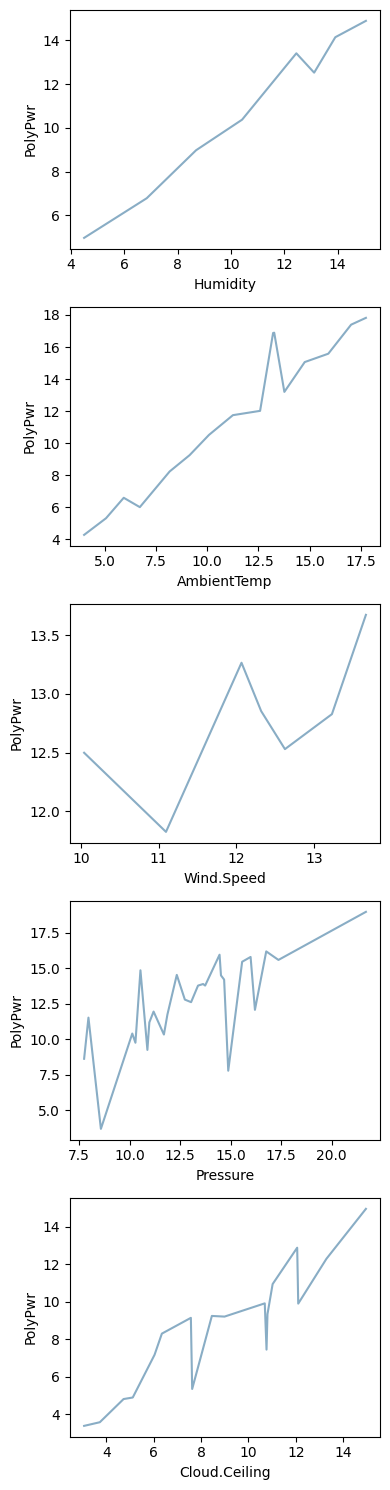

In [35]:
train_trans = treeDisc.transform(X_train)
test_trans = treeDisc.transform(X_test)

nrows = len(discretize)
_, ax = plt.subplots(nrows=nrows, figsize=(4, 3 * nrows))
for col, ax_ in zip(discretize, ax.flatten()):
    y_test.groupby(test_trans[col]).mean().plot(ax=ax_)
    ax_.set_ylabel('PolyPwr')
    plt.tight_layout()

After transformation, humidity, temperature and cloud ceiling all give a monotoonic relationship with the target, so the derived discretizations seem appropriate in those cases. Pressure and wind speed don't fare so well, so we will attempt other, perhaps simpler, approaches with those. 

In [36]:
treeDisc = DecisionTreeDiscretiser(
    cv=10, scoring='r2',
    variables=[col for col in discretize if col not in ['Pressure', 'Wind.Speed']],
    regression=True,
    param_grid={'max_depth': [2, 3, 4, 5],
                'min_samples_leaf': [5, 10, 15]})

treeDisc.fit(X_train, y_train)

DecisionTreeDiscretiser(cv=10,
                        param_grid={'max_depth': [2, 3, 4, 5],
                                    'min_samples_leaf': [5, 10, 15]},
                        scoring='r2',
                        variables=['Humidity', 'AmbientTemp', 'Cloud.Ceiling'])

In [37]:
visibility_column_index = 19

tree_pipeline = Pipeline([
    
    ('rare_label_encoder', 
     ce.RareLabelEncoder(tol=0.05,
                         n_categories=7,
                         variables=['Location'])),
    
    ('categorical_encoder',
     ce.OrdinalEncoder(encoding_method='ordered',
                       variables=['Season'])),
    
    ('categorical_encoder_loc',
     ce.OrdinalEncoder(encoding_method='arbitrary',
                       variables=['Location'])),
    
    # ('tree_discretizer',
    #  treeDisc),
    ('tree_discretizer', 
     DecisionTreeDiscretiser(cv=10, 
                             scoring='r2',
                             variables=['Cloud.Ceiling'],
                             regression=True,
                             param_grid={'max_depth': [2, 3, 4, 5],
                                         'min_samples_leaf': [5, 10, 15]})),

    
    ('rbf_month',
     RepeatingBasisFunction(remainder="passthrough",
                            n_periods=12,
                            column="month",
                            width=1.0,
                            input_range=(1,12))),
    
    ('binarizer_vis', 
     ColumnTransformer(transformers=[('binarize_vis', 
                                      Binarizer(threshold=15), 
                                      [visibility_column_index])], 
                       remainder='passthrough')),
    
    ('xgb', train.build_model())

])

scores = train.train_model(inputs=X_train, target=y_train, pipeline=tree_pipeline)

CV Average R2: 0.6608200629443457


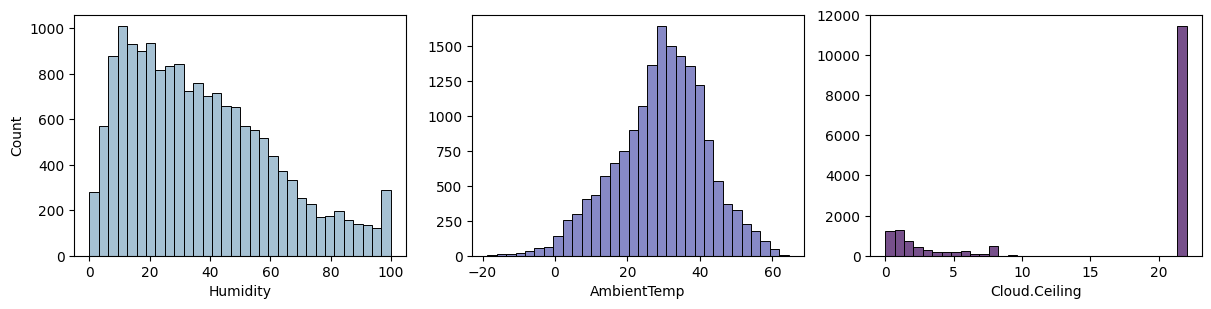

In [38]:
eda.numerical_distributions(df=X_train, features=[col for col in discretize if col not in ['Pressure', 'Wind.Speed']])

In [39]:
treeDisc = DecisionTreeDiscretiser(
    cv=10, scoring='r2',
    variables=[col for col in discretize if col not in ['Pressure', 'Wind.Speed']],
    regression=True,
    param_grid={'max_depth': [2, 3, 4, 5],
                'min_samples_leaf': [5, 10, 15]})

treeDisc.fit(X_train, y_train)
train_trans = treeDisc.transform(X_train)
test_trans = treeDisc.transform(X_test)

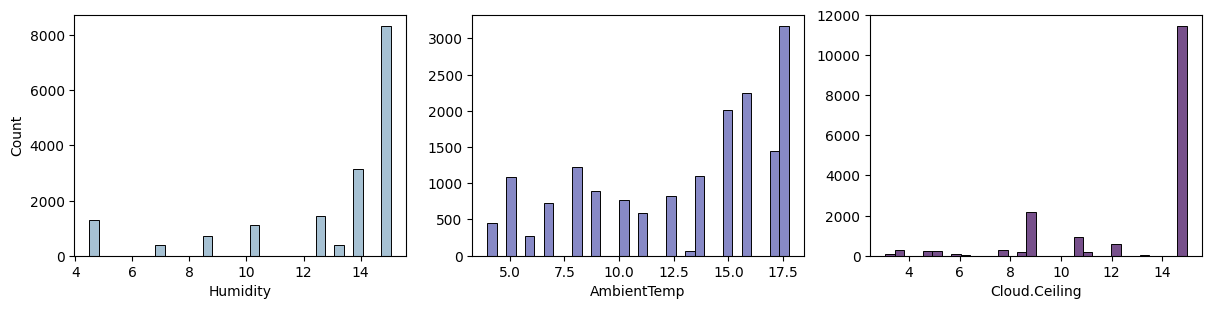

In [40]:
eda.numerical_distributions(df=train_trans, features=[col for col in discretize if col not in ['Pressure', 'Wind.Speed']])

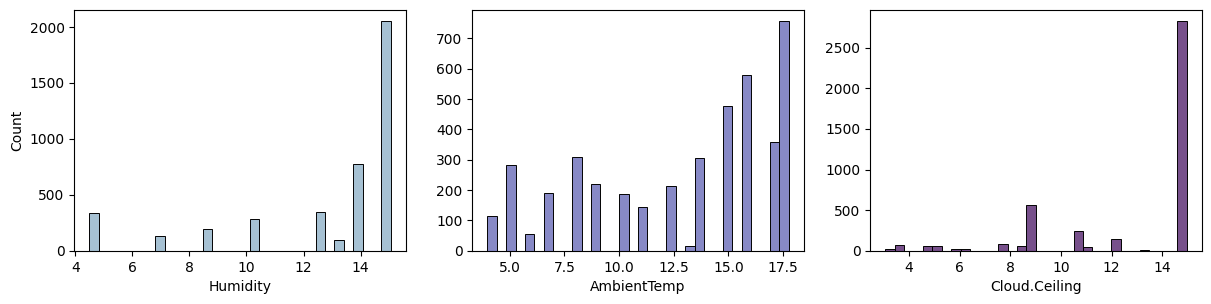

In [41]:
eda.numerical_distributions(df=test_trans, features=[col for col in discretize if col not in ['Pressure', 'Wind.Speed']])

### Summary

None of the binning strategies derived via trees helped the score but we did see an improvement by binarizing the visibility and cloud ceiling. Our new R2 is ~0.6621 with the following pipeline. 

In [45]:
pipeline

Pipeline(steps=[('rare_label_encoder',
                 RareLabelEncoder(n_categories=7, variables=['Location'])),
                ('categorical_encoder', OrdinalEncoder(variables=['Season'])),
                ('categorical_encoder_loc',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['Location'])),
                ('rbf_month',
                 RepeatingBasisFunction(column='month', input_range=(1, 12),
                                        remainder='passthrough')),
                ('b...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])